# Part1 CornerDetector
Author: Victor Badenas Crespo

## Purpose
Case study of the different effects of different corner detectors.

## Methodology
Modifying the example in [the scikit-image corner detection example](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py), the [corner detectors in the scikit image package](https://scikit-image.org/docs/stable/api/skimage.feature.html) are tested. 

Images from the [general purpose images of scikit-image](https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html) will be used to evaluate and explain the advantages and disadvantages of those corner detectors.

## Results
**PENDING**

***
## Theoretical explanations

### Fast

The FAST corner detector was originally developed by Edward Rosten and Tom Drummond, and was published in 2006. The most promising advantage of the FAST corner detector is its computational efficiency. Referring to its name, it is indeed faster than many other well-known feature extraction methods, such as difference of Gaussians (DoG) used by the SIFT, SUSAN and Harris detectors. Moreover, when machine learning techniques are applied, superior performance in terms of computation time and resources can be realised. The FAST corner detector is very suitable for real-time video processing application because of this high-speed performance.

<img style="float: right;" src="images/bresenham_circle.jpg">

FAST corner detector uses a circle of 16 pixels (a Bresenham circle of radius 3) to classify whether a candidate point p is actually a corner. Each pixel in the circle is labeled from integer number 1 to 16 clockwise. If a set of N contiguous pixels in the circle are all brighter than the intensity of candidate pixel p (denoted by Ip) plus a threshold value t or all darker than the intensity of candidate pixel p minus threshold value t, then p is classified as corner. The conditions can be written as:

- Condition 1: A set of N contiguous pixels S, $\forall x\in S$ , the intensity of x > Ip + threshold, or $I_{x}>I_{p}+t$
- Condition 2: A set of N contiguous pixels S, $\forall x\in S$, $I_{x}<I_{p}-t$

So when either of the two conditions is met, candidate p can be classified as a corner. There is a tradeoff of choosing N, the number of contiguous pixels and the threshold value t. On one hand the number of detected corner points should not be too many, on the other hand, the high performance should not be achieved by sacrificing computational efficiency. Without the improvement of machine learning, N is usually chosen as 12. A high-speed test method could be applied to exclude non-corner points.

### Harris

A corner is a point whose local neighborhood stands in two dominant and different edge directions. In other words, a corner can be interpreted as the junction of two edges, where an edge is a sudden change in image brightness. Corners are the important features in the image, and they are generally termed as interest points which are invariant to translation, rotation and illumination. Although corners are only a small percentage of the image, they contain the most important features in restoring image information, and they can be used to minimize the amount of processed data for motion tracking, image stitching, building 2D mosaics, stereo vision, image representation and other related computer vision areas.

In order to capture the corners from the image, researchers have proposed many different corner detectors including the Kanade-Lucas-Tomasi (KLT) operator and the Harris operator which are most simple, efficient and reliable for use in corner detection. These two popular methodologies are both closely associated with and based on the local structure matrix. The Harris corner detector provides good repeatability under changing illumination and rotation, and therefore, it is often used in stereo matching and image database retrieval. Although there still exists drawbacks and limitations, the Harris corner detector is still an important and fundamental technique for many computer vision applications.

Commonly, Harris corner detector algorithm can be divided into five steps.

#### Color to grayscale

If we use Harris corner detector in a color image, the first step is to convert it into a grayscale image, which will enhance the processing speed.

The value of the gray scale pixel can be computed as a weighted sums of the values R, B and G of the color image,

$\sum _{C\,\in \,\{R,B,G\}}w_{C}\cdot C$,
where, e.g., $w_{R}=0.299,\ w_{B}=0.587,\ w_{G}=1-(w_{R}+w_{B}).$

#### Spatial derivative calculation

Next, we are going to compute $I_{x}(x,y)$ and $I_{y}(x,y)$.

#### Structure tensor setup

With $I_{x}(x,y)$ , $I_{y}(x,y)$, we can construct the structure tensor $M$.

#### Harris response calculation

For $x\ll y$, one has ${\tfrac {x\cdot y}{x+y}}=x{\tfrac {1}{1+x/y}}\approx x.$ In this step, we compute the smallest eigenvalue of the structure tensor using that approximation:

$\lambda _{min}\approx {\frac {\lambda _{1}\lambda _{2}}{(\lambda _{1}+\lambda _{2})}}={\frac {\det(M)}{\mathrm {tr} (M)}}

with the trace $\mathrm {tr} (M)=m_{11}+m_{22}$.

Another commonly used Harris response calculation is shown as below,

$R=\lambda _{1}\lambda _{2}-k\cdot (\lambda _{1}+\lambda _{2})^{2}=\det(M)-k\cdot \mathrm {tr} (M)^{2}$

where $k$ is an empirically determined constant; $k\in [0.04,0.06]$ .

#### Non-maximum suppression

In order to pick up the optimal values to indicate corners, we find the local maxima as corners within the window which is a 3 by 3 filter.

### Foerstner

***
## Setup

### Library import
We import all the required Python libraries

In [13]:
from matplotlib import pyplot as plt
import skimage
from skimage import data, color, io
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from pprint import pprint

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Local library import and functions
We import all the required local libraries and user defined functions and utilities

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        cmap = plt.cm.gray if image.ndim == 2 else None
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

***
## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
# skimage data image list
images = {
    'astronaut': None,
    'binary_blobs': None,
    'brick': None,
    'colorwheel': None,
    'camera': None,
    'cat': None,
    'checkerboard': None,
    'clock': None,
    'coffee': None,
    'coins': None,
    'eagle': None,
    'grass': None,
    'gravel': None,
    'horse': None,
    'page': None,
    'text': None,
    'rocket': None
}


In [ ]:
# foerstner wrapper function to return the same response image to feed into corner_peaks
def foerstner(x, accuracy_thresh = 0.5, roundness_thresh = 0.3):
    w, q = skimage.feature.corner_foerstner(x)
    foerstner = (q > roundness_thresh) * (w > accuracy_thresh) * w
    return foerstner

In [14]:
# corner extraction method's functions
methods = {
    "fast": skimage.feature.corner_fast,
    "harris": skimage.feature.corner_harris,
    "foerstner": foerstner
}

***
## Data import
We retrieve all the required data for the analysis.

In [4]:
# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
exampleImage = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))

# Ellipse
rr, cc = ellipse(160, 175, 10, 100)
exampleImage[rr, cc] = 1

# Two squares
exampleImage[30:80, 200:250] = 1
exampleImage[80:130, 250:300] = 1

In [5]:
# load all data images
for imageName in images:
    images[imageName] = getattr(data, imageName)()
images['exampleImage'] = exampleImage

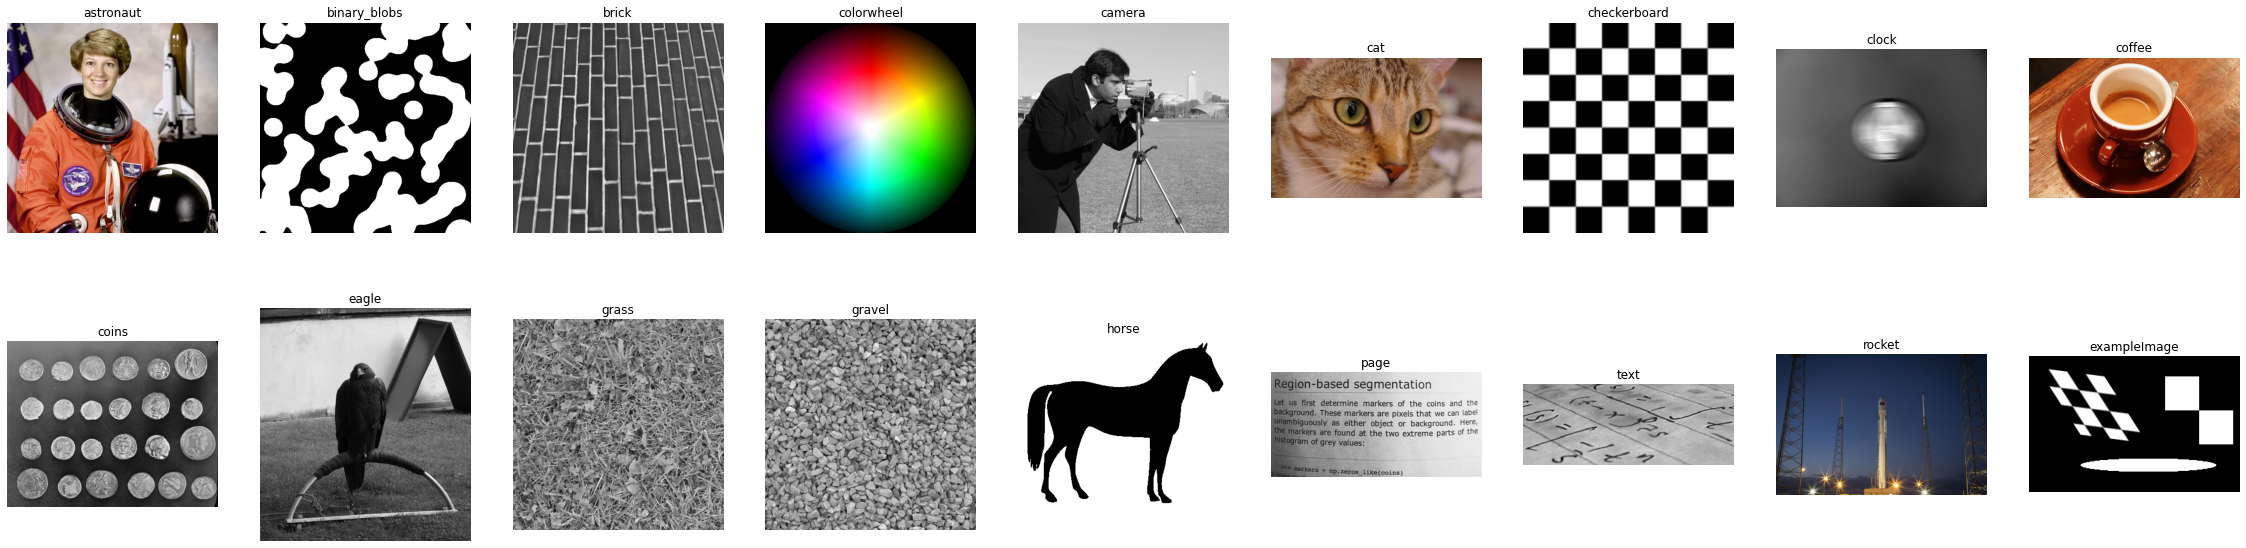

In [6]:
# plot all data images loaded in the previous cell
plotImages(images, grid=(2, int(len(images)/2)), figsize=(40, 10))
plt.show()

***
## Data processing

In [12]:
@interact(imageName=list(images.keys()), method=list(methods.keys()))
def harris(imageName='exampleImage', method='harris'):
    image = images[imageName]
    if image.ndim > 2:
        image = color.rgb2gray(image)

    coords = corner_peaks(methods[method](image), threshold_rel=0.02)
    coords_subpix = corner_subpix(image, coords, window_size=13)

    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    plt.show()


interactive(children=(Dropdown(description='imageName', index=17, options=('astronaut', 'binary_blobs', 'brick…

***

## Discussion

### Fast

### Harris

### Foerstner

***
# References
We report here relevant references:

1. The scikit-image corner detection example, https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
2. Corner detectors in the scikit image package, https://scikit-image.org/docs/stable/api/skimage.feature.html
3. General purpose images of scikit-image, https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html